# PCD Assignment 02
*   Nama: Yullase Pratiwi
*   NIM: 24/550766/PPA/06955




# 1. FUNGSI KONVOLUSI

In [23]:


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


def konvolusi_2d(gambar, kernel):


    tinggi_gambar, lebar_gambar = gambar.shape
    tinggi_kernel, lebar_kernel = kernel.shape


    padding_tinggi = tinggi_kernel // 2
    padding_lebar = lebar_kernel // 2


    gambar_padding = np.pad(gambar, ((padding_tinggi, padding_tinggi), (padding_lebar, padding_lebar)),
                           mode='constant', constant_values=0)


    hasil_konvolusi = np.zeros_like(gambar)

    # konvolusi dengan nested loop
    for baris in range(tinggi_gambar):
        for kolom in range(lebar_gambar):
            region_gambar = gambar_padding[baris:baris+tinggi_kernel, kolom:kolom+lebar_kernel]
            hasil_konvolusi[baris, kolom] = np.sum(region_gambar * kernel)

    return hasil_konvolusi

def tampilkan_detail_konvolusi(patch_gambar, kernel, hasil):

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    #  patch gambar
    axes[0].imshow(patch_gambar, cmap='gray')
    axes[0].set_title('Bagian Gambar')
    axes[0].axis('off')
    for i in range(patch_gambar.shape[0]):
        for j in range(patch_gambar.shape[1]):
            axes[0].text(j, i, f'{patch_gambar[i,j]:.0f}', ha='center', va='center',
                        color='red', fontweight='bold')

    #  kernel
    axes[1].imshow(kernel, cmap='gray')
    axes[1].set_title('Kernel')
    axes[1].axis('off')
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            axes[1].text(j, i, f'{kernel[i,j]:.2f}', ha='center', va='center',
                        color='red', fontweight='bold')

    #  hasil perkalian
    perkalian = patch_gambar * kernel
    axes[2].imshow(perkalian, cmap='gray')
    axes[2].set_title('Hasil Perkalian Element-wise')
    axes[2].axis('off')
    for i in range(perkalian.shape[0]):
        for j in range(perkalian.shape[1]):
            axes[2].text(j, i, f'{perkalian[i,j]:.1f}', ha='center', va='center',
                        color='red', fontweight='bold')

    #  hasil akhir
    axes[3].text(0.5, 0.5, f'Total = {hasil:.1f}', ha='center', va='center',
                transform=axes[3].transAxes, fontsize=20, fontweight='bold')
    axes[3].set_title('Hasil Konvolusi')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()


# 2. PEMBUATAN KERNEL SPATIAL FILTERING

In [24]:
def buat_kernel_rata_rata(ukuran):

    return np.ones((ukuran, ukuran)) / (ukuran * ukuran)

def buat_kernel_gaussian(ukuran, sigma=1.0):

    kernel = np.zeros((ukuran, ukuran))
    pusat = ukuran // 2

    # Hitung nilai untuk setiap posisi kernel
    for i in range(ukuran):
        for j in range(ukuran):
            x = i - pusat
            y = j - pusat
            kernel[i, j] = np.exp(-(x*x + y*y) / (2 * sigma * sigma))

    # Normalisasi agar jumlah total = 1
    kernel = kernel / np.sum(kernel)
    return kernel

def filter_median(gambar, ukuran_kernel):

    tinggi_gambar, lebar_gambar = gambar.shape
    padding = ukuran_kernel // 2

    # Tambahkan padding ke gambar
    gambar_padding = np.pad(gambar, ((padding, padding), (padding, padding)),
                           mode='constant', constant_values=0)

    # Siapkan array output
    hasil_filter = np.zeros_like(gambar)

    # Terapkan median filtering
    for i in range(tinggi_gambar):
        for j in range(lebar_gambar):
            # Ambil neighborhood sekitar pixel
            tetangga = gambar_padding[i:i+ukuran_kernel, j:j+ukuran_kernel]
            # Hitung median dari neighborhood
            hasil_filter[i, j] = np.median(tetangga)

    return hasil_filter

def buat_kernel_laplacian():

    return np.array([[ 0, -1,  0],
                     [-1,  4, -1],
                     [ 0, -1,  0]])


# 3. TEKNIK SHARPENING DENGAN BLURRING

In [25]:
def unsharp_masking(gambar, kernel_blur, intensitas=1.5):

    gambar_blur = konvolusi_2d(gambar, kernel_blur)
    mask = gambar - gambar_blur
    gambar_tajam = gambar + intensitas * mask
    gambar_tajam = np.clip(gambar_tajam, 0, 255)

    return gambar_tajam, gambar_blur, mask

def sharpening_laplacian(gambar):

    kernel_laplacian = buat_kernel_laplacian()

    #   Laplacian
    hasil_laplacian = konvolusi_2d(gambar, kernel_laplacian)


    gambar_tajam = gambar - hasil_laplacian
    gambar_tajam = np.clip(gambar_tajam, 0, 255)

    return gambar_tajam, hasil_laplacian

# 4. LOAD  DAN PROSES DATA

In [26]:
def muat_gambar_upload(path_file):

    try:

        img = Image.open(path_file)
        print(f"✓ Ukuran gambar asli: {img.size}")
        print(f"✓ Mode gambar asli: {img.mode}")


        img_gray = img.convert('L')

        # Resize jika terlalu besar
        ukuran_maks = 512
        if max(img_gray.size) > ukuran_maks:
            img_gray.thumbnail((ukuran_maks, ukuran_maks), Image.Resampling.LANCZOS)
            print(f"✓ Ukuran setelah resize: {img_gray.size}")


        array_gambar = np.array(img_gray)

        print(f"✓ Berhasil memuat gambar yang diupload!")
        return array_gambar

    except Exception as e:
        print(f"✗ Error saat memuat gambar: {e}")


path_gambar1 = "/content/salt_pepper.png"
path_gambar2 = "/content/bulat.png"

print("\nMemuat gambar-gambar")


print("\n--- MEMUAT GAMBAR PERTAMA ---")
if path_gambar1 is not None:
    print(f"Mencoba memuat gambar 1: {path_gambar1}")
    gambar1 = muat_gambar_upload(path_gambar1)
else:
    print("Path gambar 1 tidak diberikan.")


print(f"Gambar 1 - Dimensi: {gambar1.shape}")
print(f"Gambar 1 - Tipe data: {gambar1.dtype}")
print(f"Gambar 1 - Range pixel: {gambar1.min()} - {gambar1.max()}")


print("\n--- MEMUAT GAMBAR KEDUA ---")
if path_gambar2 is not None:
    print(f"Mencoba memuat gambar 2: {path_gambar2}")
    gambar2 = muat_gambar_upload(path_gambar2)
else:
    print("Path gambar 2 tidak diberikan.")

    gambar2 = np.roll(gambar2, 50, axis=0)
    gambar2 = np.flip(gambar2, axis=1)

print(f"Gambar 2 - Dimensi: {gambar2.shape}")
print(f"Gambar 2 - Tipe data: {gambar2.dtype}")
print(f"Gambar 2 - Range pixel: {gambar2.min()} - {gambar2.max()}")


gambar_asli = gambar1


Memuat gambar-gambar

--- MEMUAT GAMBAR PERTAMA ---
Mencoba memuat gambar 1: /content/salt_pepper.png
✓ Ukuran gambar asli: (612, 612)
✓ Mode gambar asli: RGBA
✓ Ukuran setelah resize: (512, 512)
✓ Berhasil memuat gambar yang diupload!
Gambar 1 - Dimensi: (512, 512)
Gambar 1 - Tipe data: uint8
Gambar 1 - Range pixel: 0 - 254

--- MEMUAT GAMBAR KEDUA ---
Mencoba memuat gambar 2: /content/bulat.png
✓ Ukuran gambar asli: (612, 612)
✓ Mode gambar asli: RGBA
✓ Ukuran setelah resize: (512, 512)
✓ Berhasil memuat gambar yang diupload!
Gambar 2 - Dimensi: (512, 512)
Gambar 2 - Tipe data: uint8
Gambar 2 - Range pixel: 0 - 255


# 5. DEMONSTRASI OPERASI KONVOLUSI (2 GAMBAR)


DEMONSTRASI OPERASI KONVOLUSI PADA 2 GAMBAR


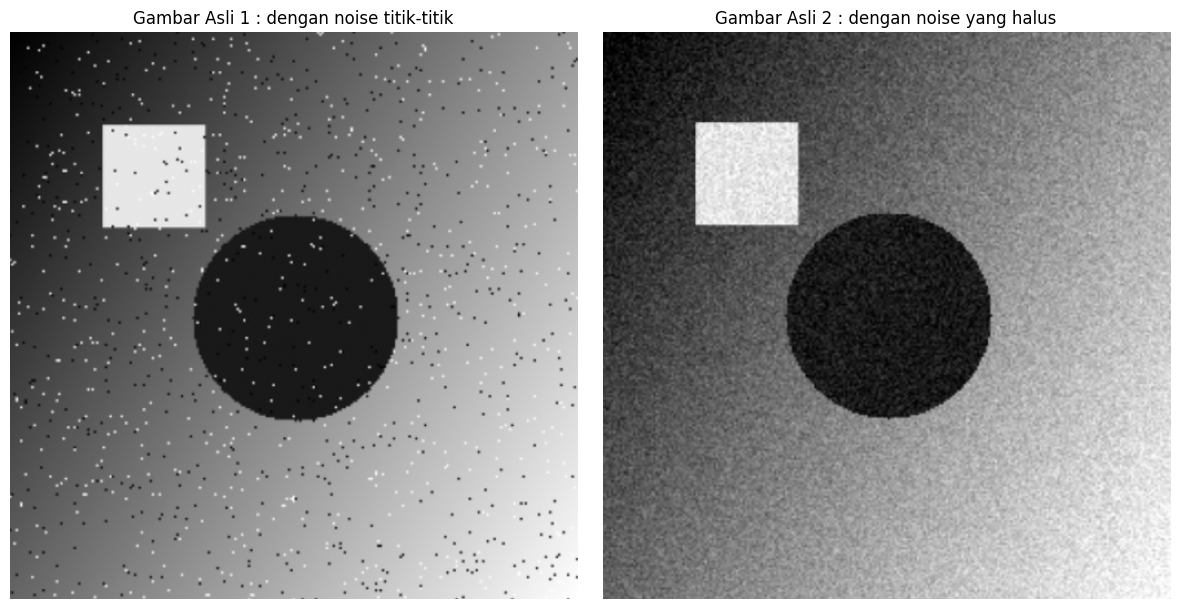


Contoh Operasi Konvolusi pada patch 3x3 dari Gambar 1:


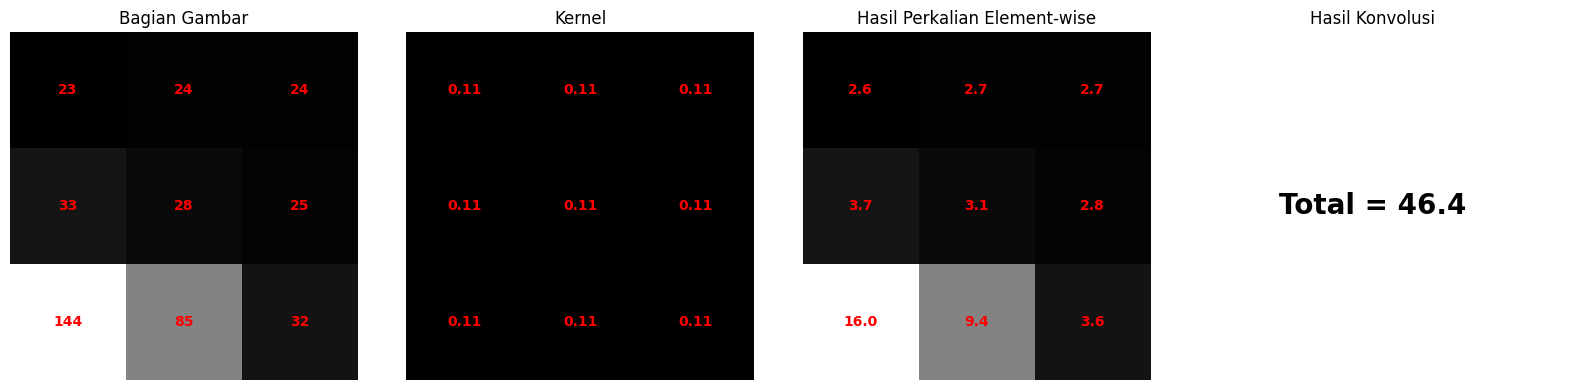


Contoh Operasi Konvolusi pada patch 3x3 dari Gambar 2:


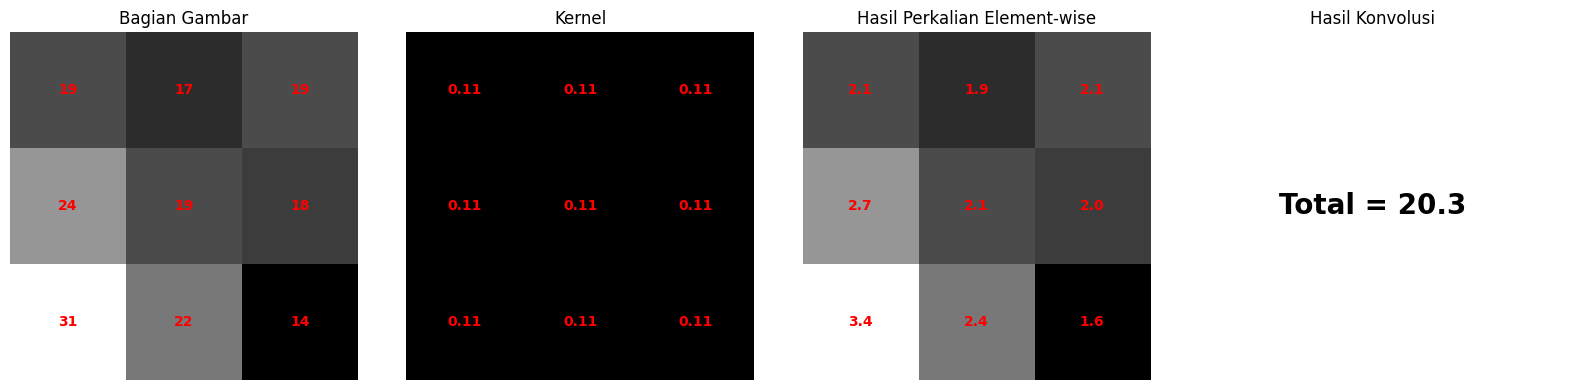


Perbandingan Hasil Konvolusi:
Patch Gambar 1 dengan noise titik-titik : 46.44
Patch Gambar 2 dengan noise yang halus : 20.33
Selisih: 26.11

Perbandingan Visual Patch dan Hasil:


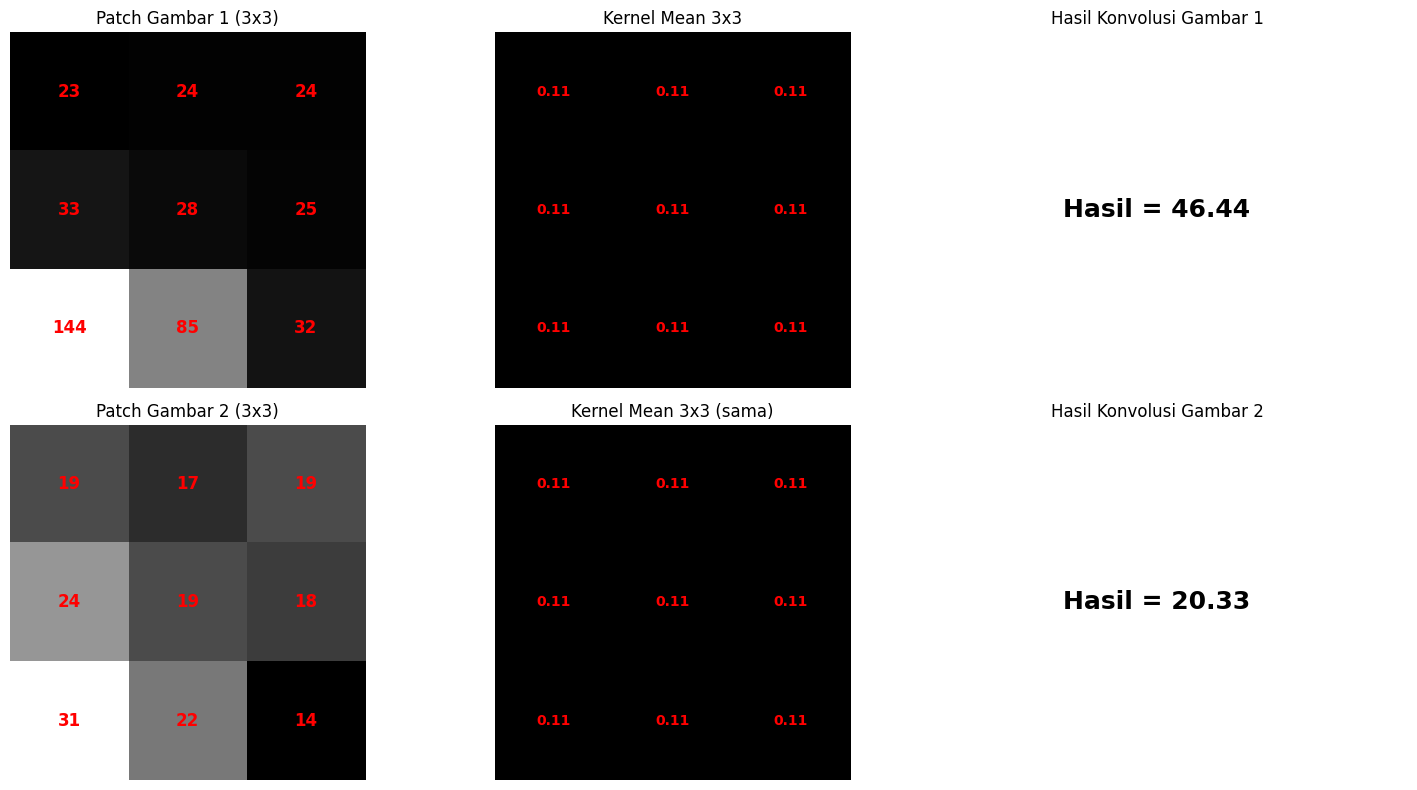

In [27]:
print("\n" + "="*50)
print("DEMONSTRASI OPERASI KONVOLUSI PADA 2 GAMBAR")
print("="*50)

#  kedua gambar asli
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(gambar1, cmap='gray')
axes[0].set_title('Gambar Asli 1 : dengan noise titik-titik')
axes[0].axis('off')

axes[1].imshow(gambar2, cmap='gray')
axes[1].set_title('Gambar Asli 2 : dengan noise yang halus')
axes[1].axis('off')

plt.tight_layout()
plt.show()


print("\nContoh Operasi Konvolusi pada patch 3x3 dari Gambar 1:")
patch1 = gambar1[50:53, 50:53]
kernel_rata_3x3 = buat_kernel_rata_rata(3)
nilai_hasil1 = np.sum(patch1 * kernel_rata_3x3)

tampilkan_detail_konvolusi(patch1, kernel_rata_3x3, nilai_hasil1)

print("\nContoh Operasi Konvolusi pada patch 3x3 dari Gambar 2:")
patch2 = gambar2[50:53, 50:53]
nilai_hasil2 = np.sum(patch2 * kernel_rata_3x3)

tampilkan_detail_konvolusi(patch2, kernel_rata_3x3, nilai_hasil2)


print(f"\nPerbandingan Hasil Konvolusi:")
print(f"Patch Gambar 1 dengan noise titik-titik : {nilai_hasil1:.2f}")
print(f"Patch Gambar 2 dengan noise yang halus : {nilai_hasil2:.2f}")
print(f"Selisih: {abs(nilai_hasil1 - nilai_hasil2):.2f}")


print("\nPerbandingan Visual Patch dan Hasil:")
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Baris 1: Gambar 1
axes[0, 0].imshow(patch1, cmap='gray')
axes[0, 0].set_title('Patch Gambar 1 (3x3)')
axes[0, 0].axis('off')
for i in range(3):
    for j in range(3):
        axes[0, 0].text(j, i, f'{patch1[i,j]:.0f}', ha='center', va='center',
                       color='red', fontweight='bold', fontsize=12)

axes[0, 1].imshow(kernel_rata_3x3, cmap='gray')
axes[0, 1].set_title('Kernel Mean 3x3')
axes[0, 1].axis('off')
for i in range(3):
    for j in range(3):
        axes[0, 1].text(j, i, f'{kernel_rata_3x3[i,j]:.2f}', ha='center', va='center',
                       color='red', fontweight='bold', fontsize=10)

axes[0, 2].text(0.5, 0.5, f'Hasil = {nilai_hasil1:.2f}', ha='center', va='center',
               transform=axes[0, 2].transAxes, fontsize=18, fontweight='bold')
axes[0, 2].set_title('Hasil Konvolusi Gambar 1')
axes[0, 2].axis('off')

# Baris 2: Gambar 2
axes[1, 0].imshow(patch2, cmap='gray')
axes[1, 0].set_title('Patch Gambar 2 (3x3)')
axes[1, 0].axis('off')
for i in range(3):
    for j in range(3):
        axes[1, 0].text(j, i, f'{patch2[i,j]:.0f}', ha='center', va='center',
                       color='red', fontweight='bold', fontsize=12)

axes[1, 1].imshow(kernel_rata_3x3, cmap='gray')
axes[1, 1].set_title('Kernel Mean 3x3 (sama)')
axes[1, 1].axis('off')
for i in range(3):
    for j in range(3):
        axes[1, 1].text(j, i, f'{kernel_rata_3x3[i,j]:.2f}', ha='center', va='center',
                       color='red', fontweight='bold', fontsize=10)

axes[1, 2].text(0.5, 0.5, f'Hasil = {nilai_hasil2:.2f}', ha='center', va='center',
               transform=axes[1, 2].transAxes, fontsize=18, fontweight='bold')
axes[1, 2].set_title('Hasil Konvolusi Gambar 2')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# 6. IMPLEMENTASI SPATIAL FILTERING


IMPLEMENTASI SPATIAL FILTERING PADA 2 GAMBAR
Memproses gambar 1
Memproses gambar 2
Kernel yang digunakan:

1. MEAN FILTER
--------------------
Kernel Mean 5x5:
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]

2. GAUSSIAN FILTER
--------------------
Kernel Gaussian 5x5 (σ=1.0):
[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]

3. MEDIAN FILTER
--------------------
Median Filter ukuran 5x5 (non-linear)


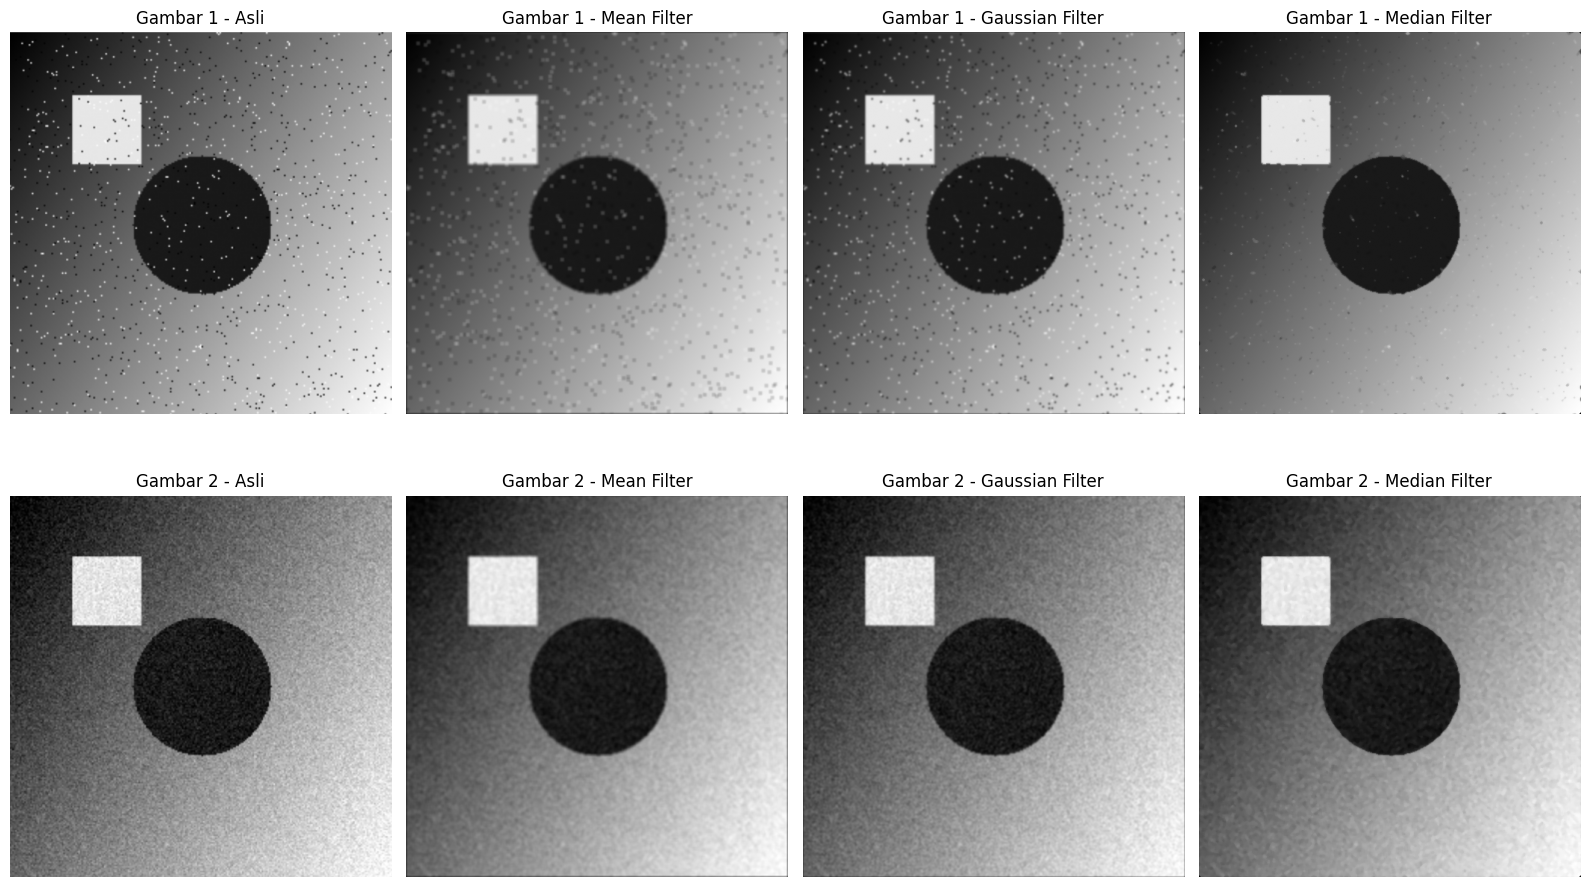

In [28]:
print("\n" + "="*50)
print("IMPLEMENTASI SPATIAL FILTERING PADA 2 GAMBAR")
print("="*50)


print("Memproses gambar 1")
# 1. Mean Filter
kernel_rata_5x5 = buat_kernel_rata_rata(5)
hasil_mean1 = konvolusi_2d(gambar1.astype(float), kernel_rata_5x5)

# 2. Gaussian Filter
kernel_gaussian_5x5 = buat_kernel_gaussian(5, sigma=1.0)
hasil_gaussian1 = konvolusi_2d(gambar1.astype(float), kernel_gaussian_5x5)

# 3. Median Filter
hasil_median1 = filter_median(gambar1.astype(float), 5)

print("Memproses gambar 2")

hasil_mean2 = konvolusi_2d(gambar2.astype(float), kernel_rata_5x5)
hasil_gaussian2 = konvolusi_2d(gambar2.astype(float), kernel_gaussian_5x5)
hasil_median2 = filter_median(gambar2.astype(float), 5)

print("Kernel yang digunakan:")
print("\n1. MEAN FILTER")
print("-" * 20)
print("Kernel Mean 5x5:")
print(kernel_rata_5x5)

print("\n2. GAUSSIAN FILTER")
print("-" * 20)
print("Kernel Gaussian 5x5 (σ=1.0):")
print(kernel_gaussian_5x5)

print("\n3. MEDIAN FILTER")
print("-" * 20)
print("Median Filter ukuran 5x5 (non-linear)")

# hasil filtering untuk kedua gambar
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

# Baris 1: Gambar 1 dan hasil filteringnya
axes[0, 0].imshow(gambar1, cmap='gray')
axes[0, 0].set_title('Gambar 1 - Asli')
axes[0, 0].axis('off')

axes[0, 1].imshow(hasil_mean1, cmap='gray')
axes[0, 1].set_title('Gambar 1 - Mean Filter')
axes[0, 1].axis('off')

axes[0, 2].imshow(hasil_gaussian1, cmap='gray')
axes[0, 2].set_title('Gambar 1 - Gaussian Filter')
axes[0, 2].axis('off')

axes[0, 3].imshow(hasil_median1, cmap='gray')
axes[0, 3].set_title('Gambar 1 - Median Filter')
axes[0, 3].axis('off')

# Baris 2: Gambar 2 dan hasil filteringnya
axes[1, 0].imshow(gambar2, cmap='gray')
axes[1, 0].set_title('Gambar 2 - Asli')
axes[1, 0].axis('off')

axes[1, 1].imshow(hasil_mean2, cmap='gray')
axes[1, 1].set_title('Gambar 2 - Mean Filter')
axes[1, 1].axis('off')

axes[1, 2].imshow(hasil_gaussian2, cmap='gray')
axes[1, 2].set_title('Gambar 2 - Gaussian Filter')
axes[1, 2].axis('off')

axes[1, 3].imshow(hasil_median2, cmap='gray')
axes[1, 3].set_title('Gambar 2 - Median Filter')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()


# 7. IMPLEMENTASI SHARPENING


IMPLEMENTASI SHARPENING PADA 2 GAMBAR
Memproses sharpening gambar 1
Memproses sharpening gambar 2

1. UNSHARP MASKING
--------------------
Kernel blur yang digunakan: Gaussian 5x5 dengan σ=2.0

2. LAPLACIAN SHARPENING
--------------------
Kernel Laplacian:
[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]


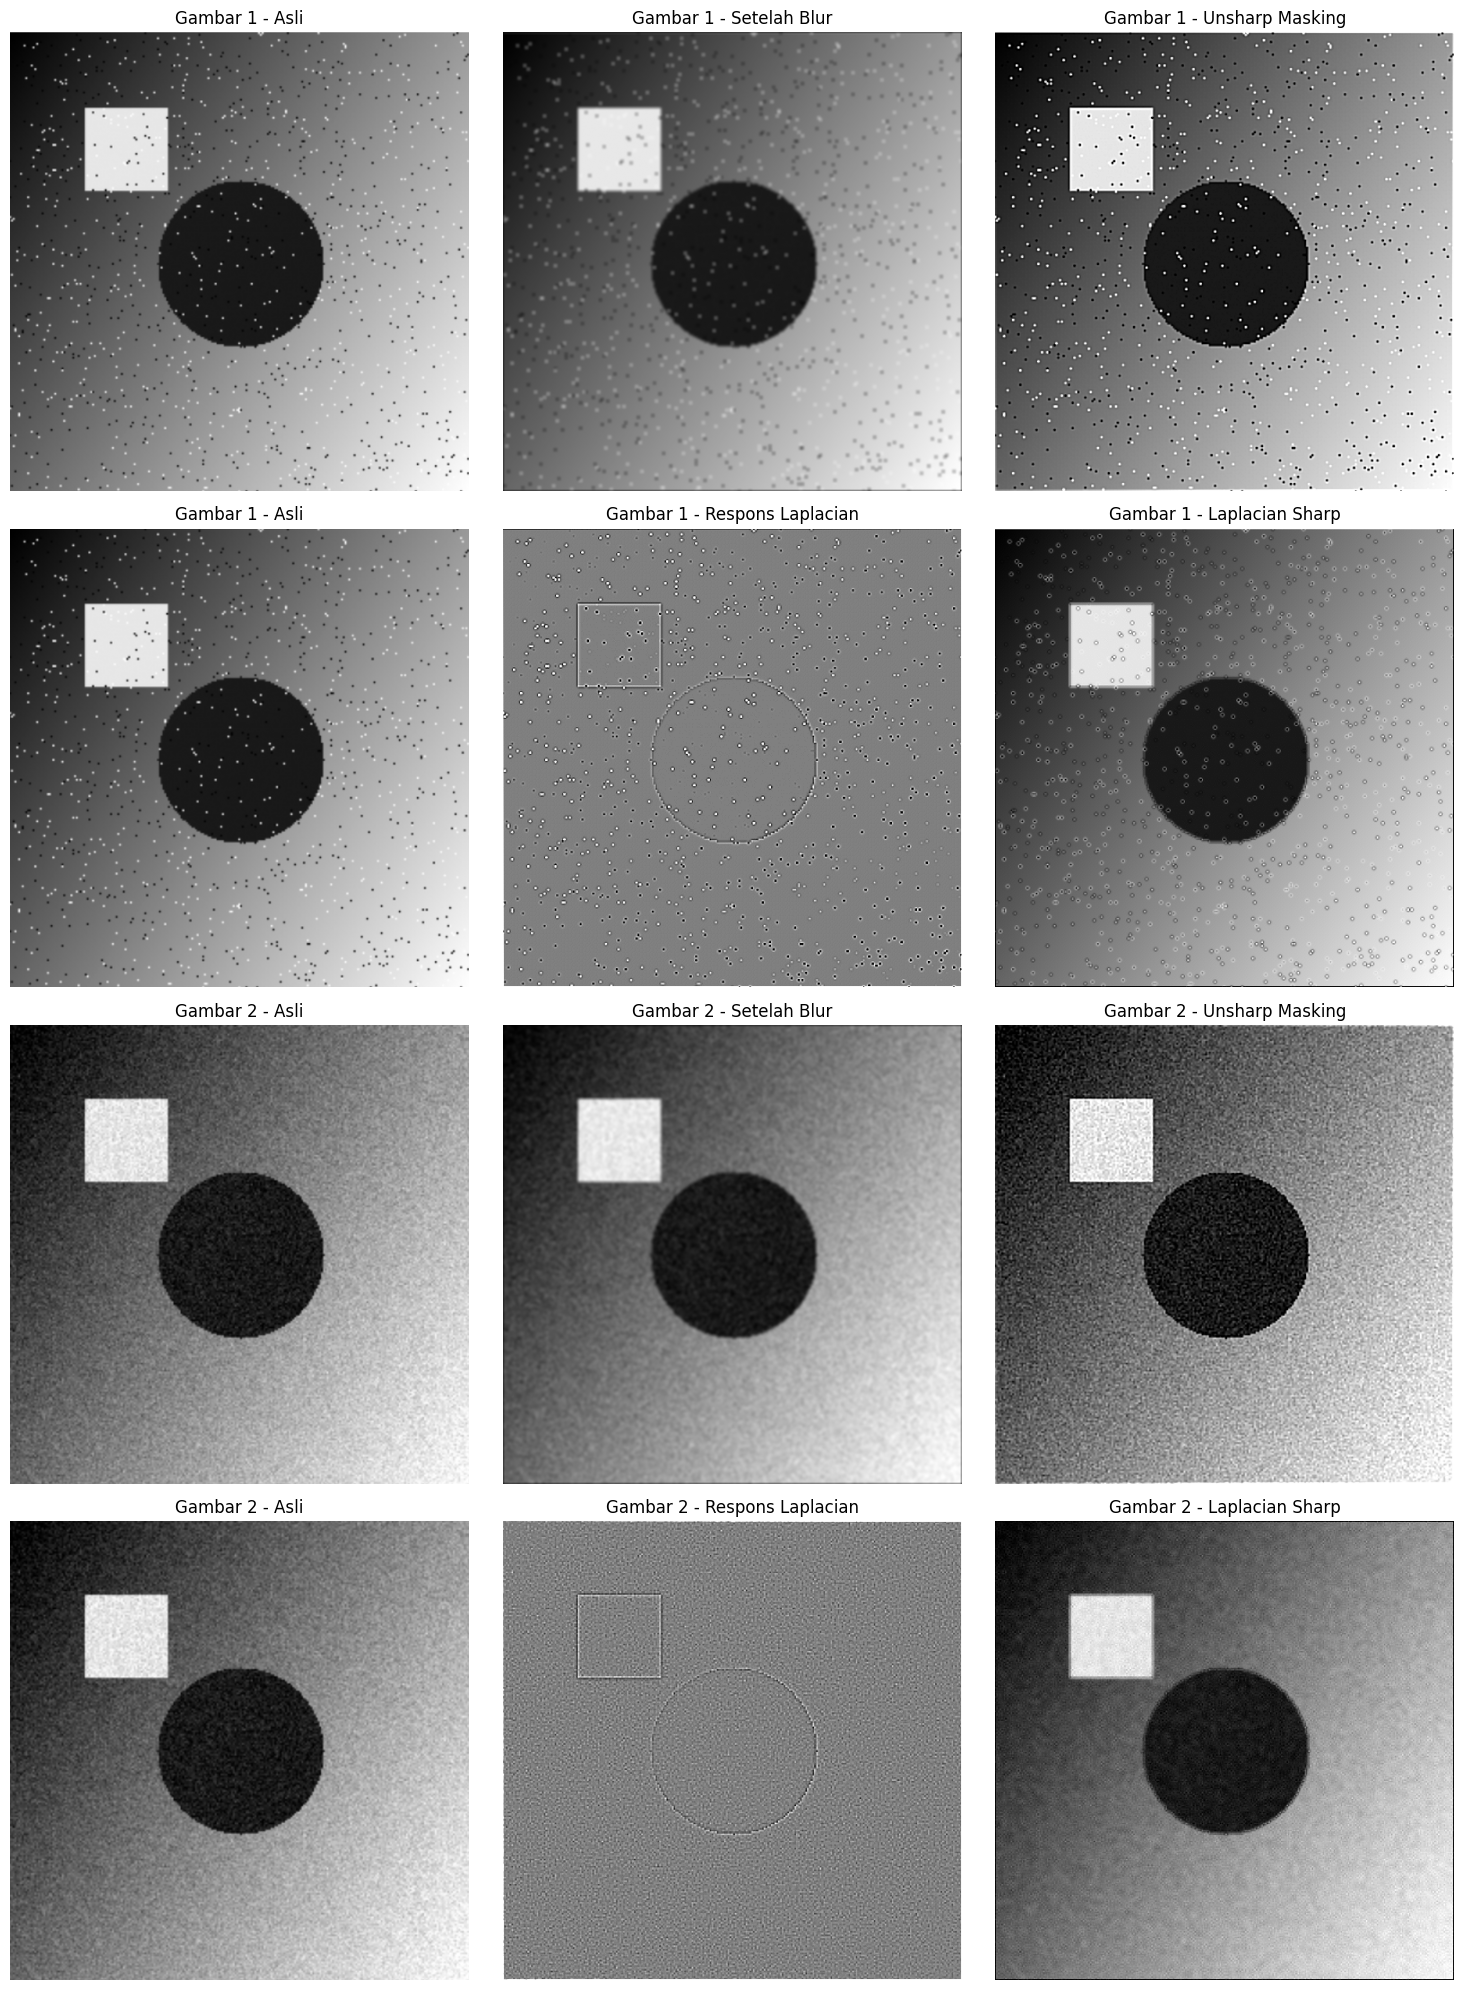

In [29]:
print("\n" + "="*50)
print("IMPLEMENTASI SHARPENING PADA 2 GAMBAR")
print("="*50)


print("Memproses sharpening gambar 1")

# 1. Unsharp Masking - Gambar 1
kernel_blur = buat_kernel_gaussian(5, sigma=2.0)
hasil_unsharp1, gambar_blur1, mask_unsharp1 = unsharp_masking(gambar1.astype(float), kernel_blur, intensitas=1.5)

# 2. Laplacian Sharpening - Gambar 1
hasil_laplacian_sharp1, respons_laplacian1 = sharpening_laplacian(gambar1.astype(float))

print("Memproses sharpening gambar 2")

# Proses sharpening untuk gambar 2
hasil_unsharp2, gambar_blur2, mask_unsharp2 = unsharp_masking(gambar2.astype(float), kernel_blur, intensitas=1.5)
hasil_laplacian_sharp2, respons_laplacian2 = sharpening_laplacian(gambar2.astype(float))

print("\n1. UNSHARP MASKING")
print("-" * 20)
print("Kernel blur yang digunakan: Gaussian 5x5 dengan σ=2.0")

print("\n2. LAPLACIAN SHARPENING")
print("-" * 20)
print("Kernel Laplacian:")
print(buat_kernel_laplacian())

#  hasil sharpening untuk kedua gambar
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# GAMBAR 1 - Proses Unsharp Masking
axes[0, 0].imshow(gambar1, cmap='gray')
axes[0, 0].set_title('Gambar 1 - Asli')
axes[0, 0].axis('off')

axes[0, 1].imshow(gambar_blur1, cmap='gray')
axes[0, 1].set_title('Gambar 1 - Setelah Blur')
axes[0, 1].axis('off')

axes[0, 2].imshow(hasil_unsharp1, cmap='gray')
axes[0, 2].set_title('Gambar 1 - Unsharp Masking')
axes[0, 2].axis('off')

# GAMBAR 1 - Proses Laplacian Sharpening
axes[1, 0].imshow(gambar1, cmap='gray')
axes[1, 0].set_title('Gambar 1 - Asli')
axes[1, 0].axis('off')

axes[1, 1].imshow(respons_laplacian1, cmap='gray', vmin=-100, vmax=100)
axes[1, 1].set_title('Gambar 1 - Respons Laplacian')
axes[1, 1].axis('off')

axes[1, 2].imshow(hasil_laplacian_sharp1, cmap='gray')
axes[1, 2].set_title('Gambar 1 - Laplacian Sharp')
axes[1, 2].axis('off')

# GAMBAR 2 - Proses Unsharp Masking
axes[2, 0].imshow(gambar2, cmap='gray')
axes[2, 0].set_title('Gambar 2 - Asli')
axes[2, 0].axis('off')

axes[2, 1].imshow(gambar_blur2, cmap='gray')
axes[2, 1].set_title('Gambar 2 - Setelah Blur')
axes[2, 1].axis('off')

axes[2, 2].imshow(hasil_unsharp2, cmap='gray')
axes[2, 2].set_title('Gambar 2 - Unsharp Masking')
axes[2, 2].axis('off')

# GAMBAR 2 - Proses Laplacian Sharpening
axes[3, 0].imshow(gambar2, cmap='gray')
axes[3, 0].set_title('Gambar 2 - Asli')
axes[3, 0].axis('off')

axes[3, 1].imshow(respons_laplacian2, cmap='gray', vmin=-100, vmax=100)
axes[3, 1].set_title('Gambar 2 - Respons Laplacian')
axes[3, 1].axis('off')

axes[3, 2].imshow(hasil_laplacian_sharp2, cmap='gray')
axes[3, 2].set_title('Gambar 2 - Laplacian Sharp')
axes[3, 2].axis('off')

plt.tight_layout()
plt.show()


# 8. ANALISIS KERNEL DAN DISKUSI

In [30]:


print("\n" + "="*50)
print("ANALISIS KERNEL DAN KASUS YANG COCOK")
print("="*50)

print("""
ANALISIS KERNEL DAN PENGGUNAAN YANG TEPAT:

1. MEAN FILTER (Filter Rata-rata)
   Sifat:
   - Menghaluskan gambar dengan cara merata-rata pixel dalam neighborhood
   - Mengurangi noise tapi juga mengurangi detail

   Cocok digunakan untuk:
   ✓ Menghilangkan noise uniform (salt noise, pepper noise)
   ✓ Pre-processing sebelum deteksi tepi
   ✓ Smoothing gambar dengan noise yang tidak terlalu berat

   Tidak cocok untuk:
   ✗ Gambar dengan detail halus yang penting
   ✗ Noise impulsive yang berat

2. GAUSSIAN FILTER
   Sifat:
   - Memberikan bobot lebih tinggi pada pixel tengah
   - Menghasilkan smoothing yang lebih natural
   - Mempertahankan tepi lebih baik dibanding mean filter

   Cocok digunakan untuk:
   ✓ Menghilangkan Gaussian noise
   ✓ Pre-processing untuk deteksi tepi (misal Canny edge detection)
   ✓ Efek blur artistik
   ✓ Multi-scale image processing

   Tidak cocok untuk:
   ✗ Mempertahankan detail yang sangat tajam
   ✗ Penghilangan impulse noise

3. MEDIAN FILTER
   Sifat:
   - Filter non-linear yang mengambil nilai median
   - Sangat efektif untuk impulse noise
   - Mempertahankan tepi dengan baik

   Cocok digunakan untuk:
   ✓ Menghilangkan salt-and-pepper noise
   ✓ Impulse noise removal
   ✓ Mempertahankan tepi sambil mengurangi noise

   Tidak cocok untuk:
   ✗ Gaussian noise
   ✗ Ketika diperlukan operasi linear

4. LAPLACIAN SHARPENING
   Sifat:
   - Mendeteksi perubahan intensitas (turunan kedua)
   - Meningkatkan kontras pada tepi
   - Sensitif terhadap noise

   Cocok digunakan untuk:
   ✓ Meningkatkan ketajaman tepi
   ✓ Detail enhancement
   ✓ Gambar yang agak blur

   Tidak cocok untuk:
   ✗ Gambar dengan noise tinggi
   ✗ Gambar yang sudah sangat tajam (bisa menimbulkan artifact)
""")


ANALISIS KERNEL DAN KASUS YANG COCOK

ANALISIS KERNEL DAN PENGGUNAAN YANG TEPAT:

1. MEAN FILTER (Filter Rata-rata)
   Sifat:
   - Menghaluskan gambar dengan cara merata-rata pixel dalam neighborhood
   - Mengurangi noise tapi juga mengurangi detail
   
   Cocok digunakan untuk:
   ✓ Menghilangkan noise uniform (salt noise, pepper noise)
   ✓ Pre-processing sebelum deteksi tepi
   ✓ Smoothing gambar dengan noise yang tidak terlalu berat
   
   Tidak cocok untuk:
   ✗ Gambar dengan detail halus yang penting
   ✗ Noise impulsive yang berat

2. GAUSSIAN FILTER
   Sifat:
   - Memberikan bobot lebih tinggi pada pixel tengah
   - Menghasilkan smoothing yang lebih natural
   - Mempertahankan tepi lebih baik dibanding mean filter
   
   Cocok digunakan untuk:
   ✓ Menghilangkan Gaussian noise
   ✓ Pre-processing untuk deteksi tepi (misal Canny edge detection)
   ✓ Efek blur artistik
   ✓ Multi-scale image processing
   
   Tidak cocok untuk:
   ✗ Mempertahankan detail yang sangat tajam
   ✗ P

# 9. PERBANDINGAN SEMUA METODE


PERBANDINGAN VISUAL SEMUA METODE PADA 2 GAMBAR


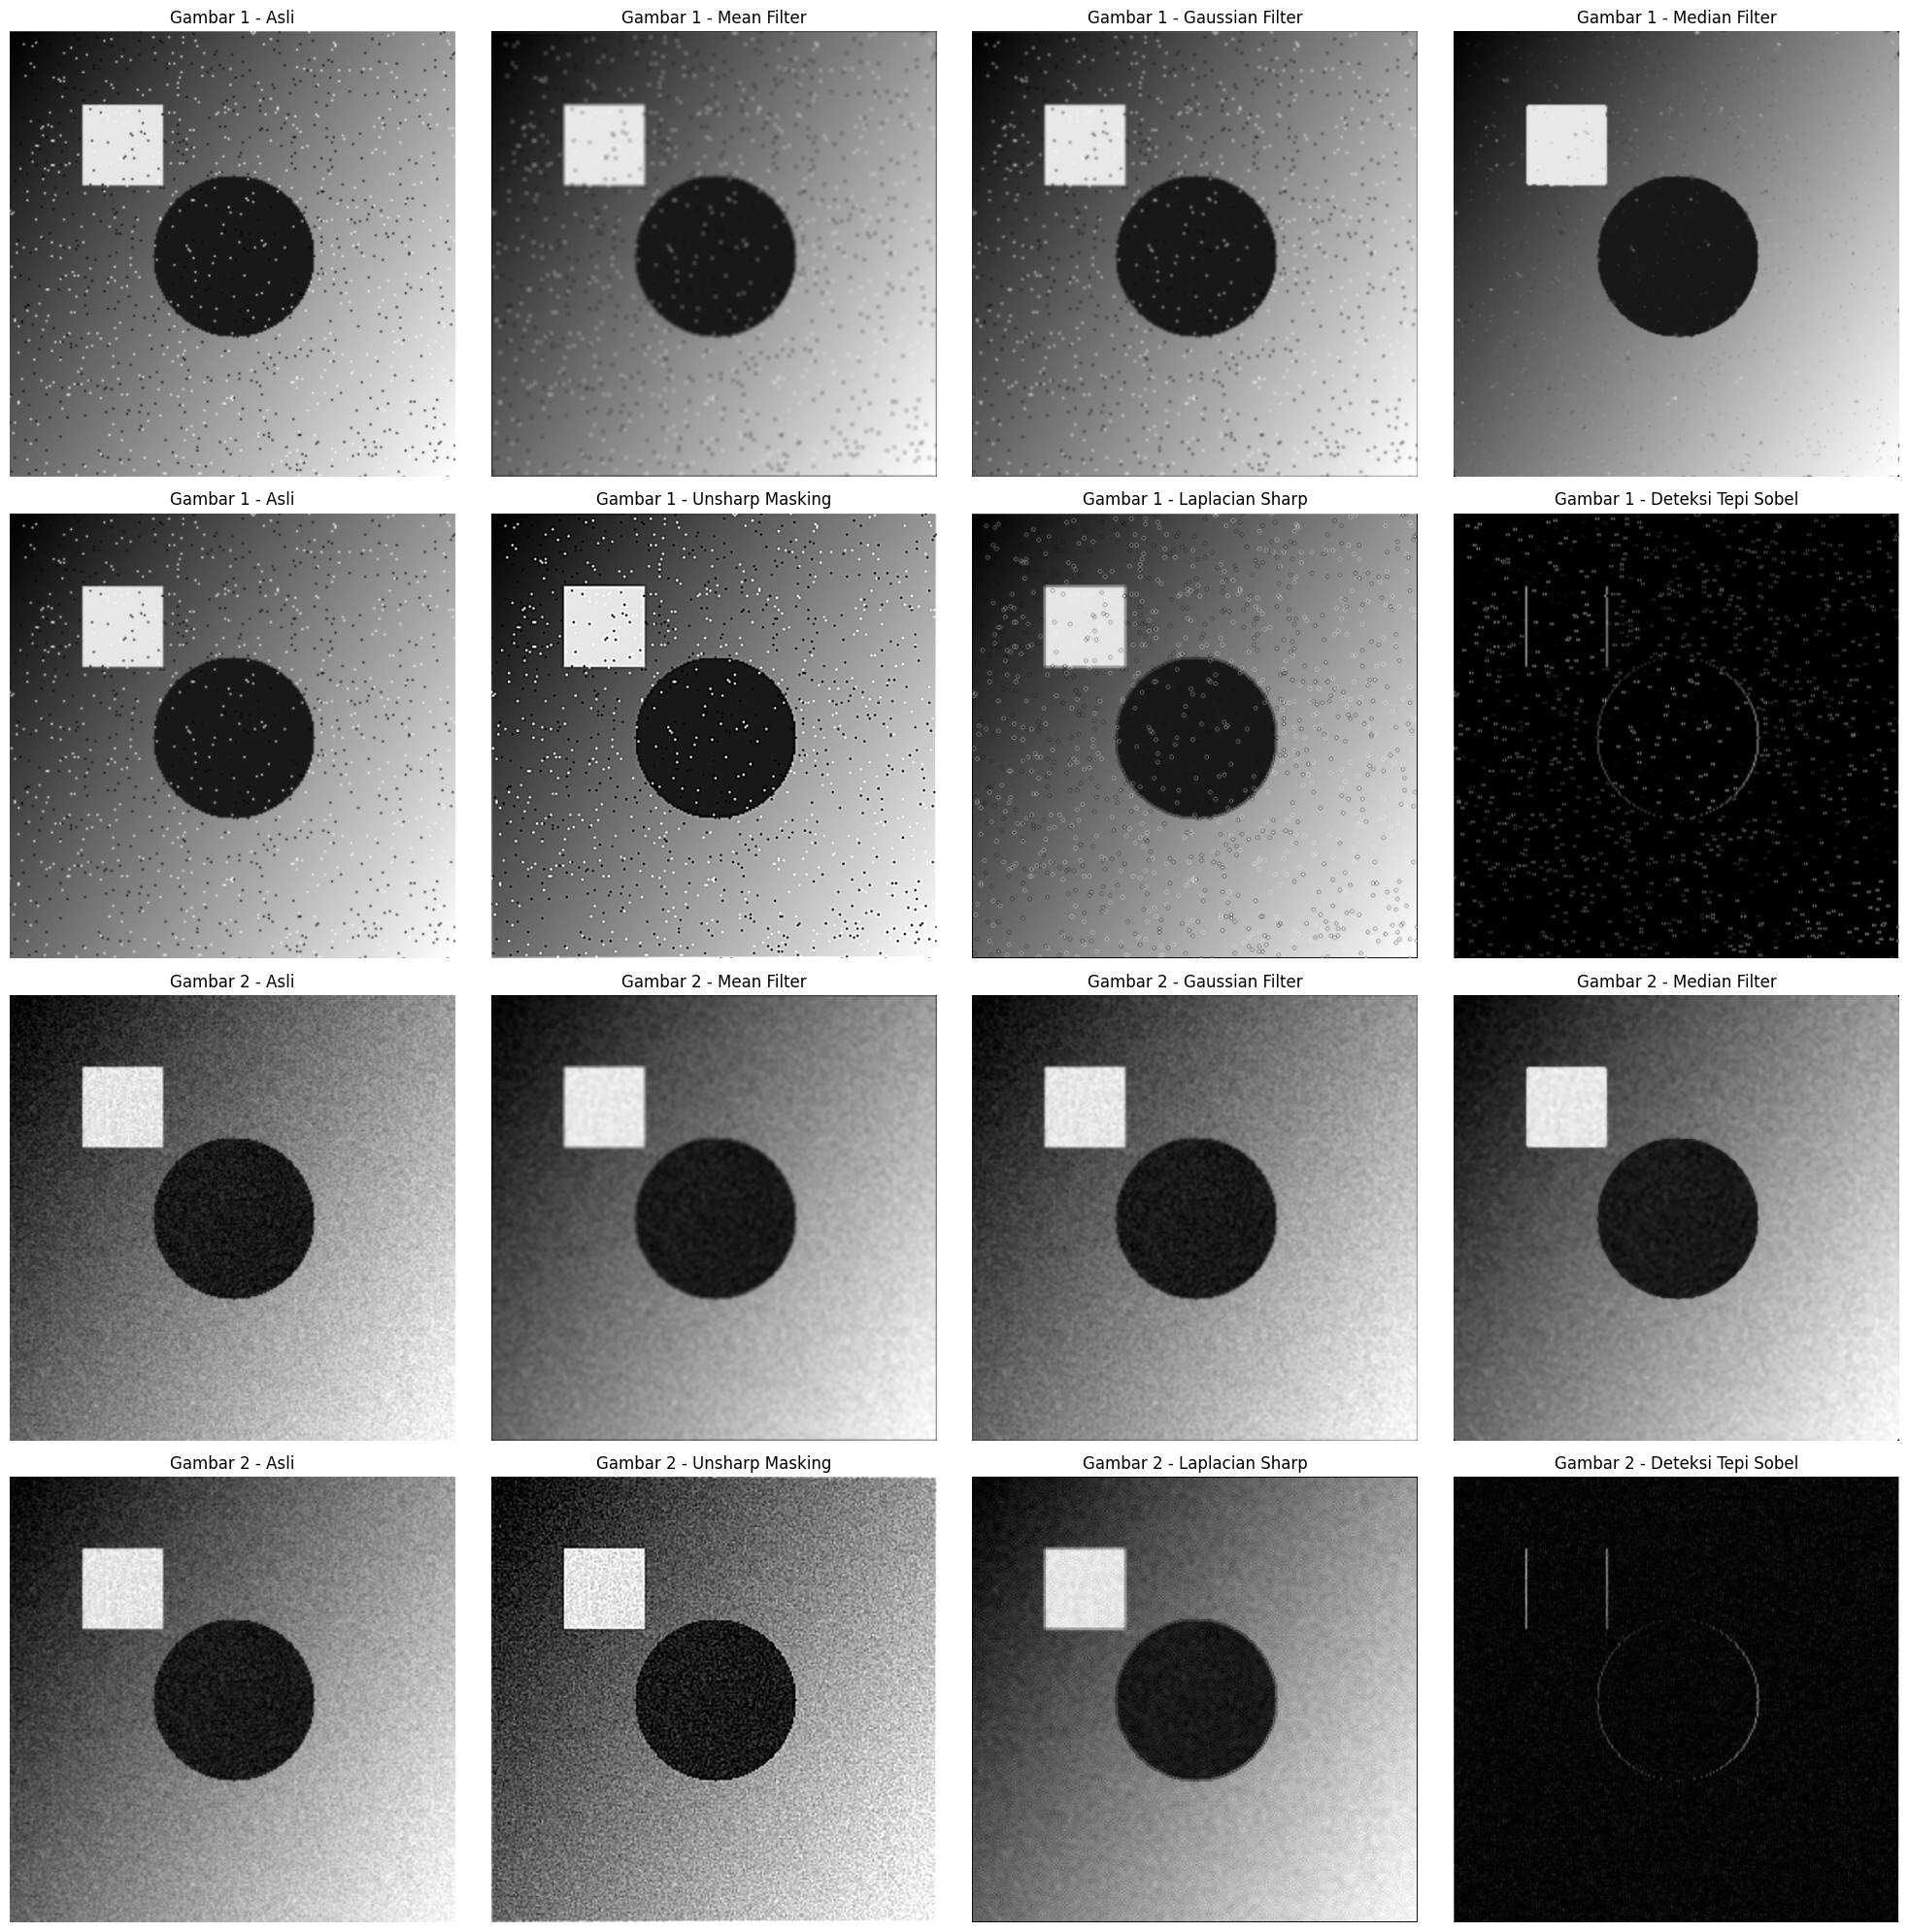


ANALISIS PERBANDINGAN EFEKTIVITAS FILTER

PERBANDINGAN EFEKTIVITAS PADA 2 GAMBAR:
- KARAKTERISTIK GAMBAR INPUT
Gambar 1:
Menampilkan pola concentric circles dengan noise impulsive yang signifikan
Terdapat elemen geometris (kotak putih, lingkaran hitam) dengan salt-and-pepper noise yang terdistribusi merata
Karakteristik: High-frequency noise dengan impulse characteristics

Gambar 2:
Menampilkan pola checkerboard dengan gradasi intensitas yang lebih halus
Noise level relatif lebih rendah dengan transisi yang lebih smooth
Karakteristik: Lower noise density dengan geometric patterns


Dari visualisasi di atas, kita dapat mengamati:
1. MEAN FILTER:
   - Pada gambar dengan noise uniform: Efektif mengurangi noise
   - Pada gambar dengan detail halus: Mengurangi ketajaman detail
   - Cocok untuk: Pre-processing gambar ber-noise

2. GAUSSIAN FILTER:
   - Lebih mempertahankan struktur tepi dibanding mean filter
   - Hasil smoothing lebih natural
   - Cocok untuk: Noise reduction dengan preserv

In [31]:
print("\n" + "="*50)
print("PERBANDINGAN VISUAL SEMUA METODE PADA 2 GAMBAR")
print("="*50)

# Buat perbandingan
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# BARIS 1: Gambar 1 : Metode filtering
axes[0, 0].imshow(gambar1, cmap='gray')
axes[0, 0].set_title('Gambar 1 - Asli', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(hasil_mean1, cmap='gray')
axes[0, 1].set_title('Gambar 1 - Mean Filter', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(hasil_gaussian1, cmap='gray')
axes[0, 2].set_title('Gambar 1 - Gaussian Filter', fontsize=12)
axes[0, 2].axis('off')

axes[0, 3].imshow(hasil_median1, cmap='gray')
axes[0, 3].set_title('Gambar 1 - Median Filter', fontsize=12)
axes[0, 3].axis('off')

# BARIS 2: Gambar 1 : Metode sharpening dan edge detection
axes[1, 0].imshow(gambar1, cmap='gray')
axes[1, 0].set_title('Gambar 1 - Asli', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(hasil_unsharp1, cmap='gray')
axes[1, 1].set_title('Gambar 1 - Unsharp Masking', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(hasil_laplacian_sharp1, cmap='gray')
axes[1, 2].set_title('Gambar 1 - Laplacian Sharp', fontsize=12)
axes[1, 2].axis('off')

# Edge detection untuk gambar 1
kernel_sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
hasil_edge1 = konvolusi_2d(gambar1.astype(float), kernel_sobel_x)
axes[1, 3].imshow(np.abs(hasil_edge1), cmap='gray')
axes[1, 3].set_title('Gambar 1 - Deteksi Tepi Sobel', fontsize=12)
axes[1, 3].axis('off')

# BARIS 3: Gambar 2 : Metode filtering
axes[2, 0].imshow(gambar2, cmap='gray')
axes[2, 0].set_title('Gambar 2 - Asli', fontsize=12)
axes[2, 0].axis('off')

axes[2, 1].imshow(hasil_mean2, cmap='gray')
axes[2, 1].set_title('Gambar 2 - Mean Filter', fontsize=12)
axes[2, 1].axis('off')

axes[2, 2].imshow(hasil_gaussian2, cmap='gray')
axes[2, 2].set_title('Gambar 2 - Gaussian Filter', fontsize=12)
axes[2, 2].axis('off')

axes[2, 3].imshow(hasil_median2, cmap='gray')
axes[2, 3].set_title('Gambar 2 - Median Filter', fontsize=12)
axes[2, 3].axis('off')

# BARIS 4: Gambar 2 :  Metode sharpening dan edge detection
axes[3, 0].imshow(gambar2, cmap='gray')
axes[3, 0].set_title('Gambar 2 - Asli', fontsize=12)
axes[3, 0].axis('off')

axes[3, 1].imshow(hasil_unsharp2, cmap='gray')
axes[3, 1].set_title('Gambar 2 - Unsharp Masking', fontsize=12)
axes[3, 1].axis('off')

axes[3, 2].imshow(hasil_laplacian_sharp2, cmap='gray')
axes[3, 2].set_title('Gambar 2 - Laplacian Sharp', fontsize=12)
axes[3, 2].axis('off')

# Edge detection untuk gambar 2
hasil_edge2 = konvolusi_2d(gambar2.astype(float), kernel_sobel_x)
axes[3, 3].imshow(np.abs(hasil_edge2), cmap='gray')
axes[3, 3].set_title('Gambar 2 - Deteksi Tepi Sobel', fontsize=12)
axes[3, 3].axis('off')

plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("ANALISIS PERBANDINGAN EFEKTIVITAS FILTER")
print("="*50)

print("""
PERBANDINGAN EFEKTIVITAS PADA 2 GAMBAR:
- KARAKTERISTIK GAMBAR INPUT
Gambar 1:
Menampilkan pola concentric circles dengan noise impulsive yang signifikan
Terdapat elemen geometris (kotak putih, lingkaran hitam) dengan salt-and-pepper noise yang terdistribusi merata
Karakteristik: High-frequency noise dengan impulse characteristics

Gambar 2:
Menampilkan pola checkerboard dengan gradasi intensitas yang lebih halus
Noise level relatif lebih rendah dengan transisi yang lebih smooth
Karakteristik: Lower noise density dengan geometric patterns
""")

print("""
Dari visualisasi di atas, kita dapat mengamati:
1. MEAN FILTER:
   - Pada gambar dengan noise uniform: Efektif mengurangi noise
   - Pada gambar dengan detail halus: Mengurangi ketajaman detail
   - Cocok untuk: Pre-processing gambar ber-noise

2. GAUSSIAN FILTER:
   - Lebih mempertahankan struktur tepi dibanding mean filter
   - Hasil smoothing lebih natural
   - Cocok untuk: Noise reduction dengan preservasi tepi

3. MEDIAN FILTER:
   - Sangat efektif untuk salt-and-pepper noise
   - Mempertahankan tepi dengan baik
   - Cocok untuk: Impulse noise removal

4. UNSHARP MASKING:
   - Meningkatkan ketajaman tanpa amplifikasi noise berlebihan
   - Hasil terlihat lebih natural
   - Cocok untuk: General purpose sharpening

5. LAPLACIAN SHARPENING:
   - Lebih agresif dalam meningkatkan kontras tepi
   - Bisa mengamplifikasi noise jika gambar ber-noise
   - Cocok untuk: Gambar dengan noise rendah

KESIMPULAN PRAKTIS:
- Pilihan filter bergantung pada karakteristik gambar input
- Kombinasi beberapa filter sering memberikan hasil optimal
- Testing pada berbagai jenis gambar penting untuk validasi metode
- pemilihan algoritma filtering harus disesuaikan dengan karakteristik noise yang dominan.
Untuk impulse noise, median filtering merupakan first-choice solution.
Untuk Gaussian noise atau noise terdistribusi uniform, Gaussian filtering memberikan hasil yang lebih natural.
""")


# 10. DISKUSI AKHIR

In [32]:


print("\n" + "="*60)
print("DISKUSI: KAPAN MEMAKAI FILTERING VS METODE PIXEL-BASED")
print("="*60)

print("""
SPATIAL FILTERING vs PIXEL-BASED PROCESSING

GUNAKAN SPATIAL FILTERING KETIKA:

1. PENGURANGAN NOISE
   - Filtering lebih efektif untuk menghilangkan noise yang punya pola spasial
   - Contoh: Gaussian filter untuk Gaussian noise, Median filter untuk impulse noise
   - Metode pixel-based tidak bisa mempertimbangkan konteks neighborhood

2. PENINGKATAN/DETEKSI TEPI
   - Filtering bisa mendeteksi pola lokal seperti tepi dan sudut
   - Operator seperti Sobel, Laplacian butuh informasi neighborhood
   - Pixel-based tidak bisa mendeteksi gradien atau perubahan lokal

3. ANALISIS TEKSTUR
   - Filtering bisa menganalisis pola tekstur lokal
   - Local Binary Pattern, Gabor filter butuh operasi neighborhood
   - Pixel-based tidak bisa menganalisis struktur tekstur

4. SMOOTHING/BLURRING
   - Filtering diperlukan untuk operasi smoothing yang natural
   - Mean, Gaussian, bilateral filter mempertimbangkan pixel tetangga
   - Pixel-based tidak bisa menghasilkan efek smoothing

GUNAKAN PIXEL-BASED PROCESSING KETIKA:

1. PENYESUAIAN BRIGHTNESS/CONTRAST
   - Operasi yang cuma bergantung pada nilai pixel individual
   - Histogram equalization, gamma correction
   - Lebih efisien secara komputasi

2. THRESHOLDING
   - Konversi ke binary image berdasarkan threshold
   - Tidak butuh informasi neighborhood
   - Operasi point-wise yang sederhana

3. KONVERSI COLOR SPACE
   - RGB ke HSV, RGB ke Lab conversion
   - Operasi matematis sederhana per pixel
   - Tidak butuh konteks spasial

4. OPERASI ARITMATIKA SEDERHANA
   - Penjumlahan gambar, pengurangan, perkalian
   - Operasi yang sifatnya element-wise
   - Lebih cepat dan efisien

KESIMPULAN:
- Spatial filtering diperlukan ketika operasi bergantung pada neighborhood/konteks spasial
- Pixel-based method cocok untuk operasi yang cuma bergantung pada nilai individual pixel
- Kombinasi kedua metode sering diperlukan untuk aplikasi computer vision yang kompleks
- Pemilihan metode bergantung pada tujuan, karakteristik gambar, dan trade-off efisiensi komputasi

""")






DISKUSI: KAPAN MEMAKAI FILTERING VS METODE PIXEL-BASED

SPATIAL FILTERING vs PIXEL-BASED PROCESSING

GUNAKAN SPATIAL FILTERING KETIKA:

1. PENGURANGAN NOISE
   - Filtering lebih efektif untuk menghilangkan noise yang punya pola spasial
   - Contoh: Gaussian filter untuk Gaussian noise, Median filter untuk impulse noise
   - Metode pixel-based tidak bisa mempertimbangkan konteks neighborhood

2. PENINGKATAN/DETEKSI TEPI
   - Filtering bisa mendeteksi pola lokal seperti tepi dan sudut
   - Operator seperti Sobel, Laplacian butuh informasi neighborhood
   - Pixel-based tidak bisa mendeteksi gradien atau perubahan lokal

3. ANALISIS TEKSTUR
   - Filtering bisa menganalisis pola tekstur lokal
   - Local Binary Pattern, Gabor filter butuh operasi neighborhood
   - Pixel-based tidak bisa menganalisis struktur tekstur

4. SMOOTHING/BLURRING
   - Filtering diperlukan untuk operasi smoothing yang natural
   - Mean, Gaussian, bilateral filter mempertimbangkan pixel tetangga
   - Pixel-based tida